In [1]:
from __future__ import print_function
from __future__ import absolute_import

In [2]:
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os

import numpy as np

In [5]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')

Pysaliency
==========

Saliency Map Models
----------------------

`pysaliency` comes with a variety of features to evaluate saliency map models. This notebooks demonstrates these features.

First we load the MIT1003 dataset:

In [6]:
import sys
import pysaliency
from pysaliency.external_datasets.sjtuvis import TextDescriptor

data_location = "../../datasets"
mit_stimuli, mit_fixations = pysaliency.external_datasets.get_mit1003(location=data_location)
text_descriptor = TextDescriptor('../../datasets/test/original_sjtuvis_dataset/text.xlsx')
mit_stimuli, mit_fixations = pysaliency.external_datasets.get_sjtu_vis(original_dataset_path="../../datasets/test/original_sjtuvis_dataset", location=data_location, text_descriptor=text_descriptor)

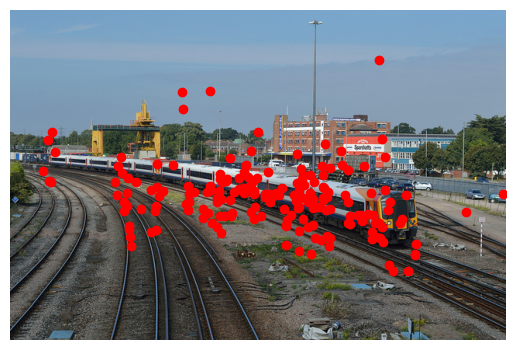

In [7]:
index = 0
plt.imshow(mit_stimuli.stimuli[index])
f = mit_fixations[mit_fixations.n == index]
plt.scatter(f.x, f.y, color='r')
_ = plt.axis('off')

As some evaluation methods can take quite a long time to run, we prepare a smaller dataset consisting of only the first 10 stimuli:

In [8]:
# cutoff = 10
# short_stimuli = pysaliency.FileStimuli(filenames=mit_stimuli.filenames[:cutoff])
# short_fixations = mit_fixations[mit_fixations.n < cutoff]
# aim = pysaliency.AIM(location='../../models', caching=False)
# print(short_stimuli[0].stimulus_data.shape, np.max(short_stimuli[0].stimulus_data.shape), np.min(short_stimuli[0].stimulus_data.shape))
# smap = aim.saliency_map(short_stimuli[0])
# plt.imshow(smap)
# plt.show()
# print(smap.shape, np.min(smap), np.max(smap))
# model = aim

My saliency map model.

In [9]:
import torch
from PIL import Image
from lavis.models import load_model_and_preprocess
from lavis.processors import load_processor
from matplotlib import pyplot as plt
from lavis.common.gradcam import getAttMap
from lavis.models.blip_models.blip_image_text_matching import compute_gradcam
import numpy as np
import pysaliency

class MySaliencyMapModel(pysaliency.SaliencyMapModel):
    
    def _saliency_map(self, stimulus, text_description="People are walking into the houses with cars parking along the street."):
        # plt.show(stimulus)
        return self.evaluate_saliency_map(stimulus[...,:3], "large", text_description)
    
    def evaluate_saliency_map(self, raw_image, model_path, caption, block_num=7, dst_w=720):
        # Setup device to use
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Load model and preprocessors
        model, vis_processors, text_processors = load_model_and_preprocess("blip_image_text_matching", model_path, device=device, is_eval=True)
        print(raw_image.shape, raw_image.dtype, np.max(raw_image), np.min(raw_image))
        raw_image = Image.fromarray(np.uint8(raw_image)).convert('RGB')
        # raw_image.show()
        # Plot utilities for GradCam
        w, h = raw_image.size
        scaling_factor = dst_w / w
        resized_img = raw_image.resize((int(w * scaling_factor), int(h * scaling_factor)))
        norm_img = np.float32(resized_img) / 255

        # Preprocess image and text inputs
        img = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
        txt = text_processors["eval"](caption)

        # Compute GradCam
        txt_tokens = model.tokenizer(txt, return_tensors="pt").to(device)
        gradcam, _ = compute_gradcam(model, img, txt, txt_tokens, block_num=block_num)

        # Average GradCam for the full image
        avg_gradcam = getAttMap(norm_img, gradcam[0][1], blur=True)

        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(avg_gradcam)
        ax.set_yticks([])
        ax.set_xticks([])

        # GradCam for each token
        num_image = len(txt_tokens.input_ids[0]) - 2
        fig, ax = plt.subplots(num_image, 1, figsize=(15, 5 * num_image))

        gradcam_iter = iter(gradcam[0][2:-1])
        token_id_iter = iter(txt_tokens.input_ids[0][1:-1])

        for i, (gradcam, token_id) in enumerate(zip(gradcam_iter, token_id_iter)):
            word = model.tokenizer.decode([token_id])
            gradcam_image = getAttMap(norm_img, gradcam, blur=True)
            ax[i].imshow(gradcam_image)
            ax[i].set_yticks([])
            ax[i].set_xticks([])
            ax[i].set_xlabel(word)

        plt.show()
        return avg_gradcam


2023-12-12 19:13:37.421131: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 19:13:37.540770: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


We will use the saliency model *AIM* by Bruce and Tsotos

Evaluating Saliency Map Models
=================

Pysaliency is able to use a variety of evaluation methods to evaluate saliency models, both saliency map based models and probabilistic models. Here we demonstrate the evaluation of saliency map models

In [11]:
import pysaliency
import os
from pysaliency.external_datasets.sjtuvis import TextDescriptor

model = pysaliency.external_models.AIM(location="../../models/", 	cache_location=os.path.join('model_caches', 'AIM'), caching=True)
text_descriptor = TextDescriptor('../../datasets/test/original_sjtuvis_dataset/text.xlsx')
mit_stimuli, mit_fixations = pysaliency.external_datasets.get_sjtu_vis(original_dataset_path="../../datasets/test/original_sjtuvis_dataset", location='../../datasets', text_descriptor=text_descriptor)
cutoff = 10
short_stimuli = pysaliency.FileStimuli(filenames=mit_stimuli.filenames[:cutoff])
short_fixations = mit_fixations[mit_fixations.n < cutoff]
auc_uniform = model.AUC(short_stimuli, short_fixations, nonfixations='uniform', verbose=True)
auc_shuffled = model.AUC(short_stimuli, short_fixations, nonfixations='shuffled', verbose=True)
auc_identical_nonfixations = model.AUC(short_stimuli, short_fixations, nonfixations=short_fixations, verbose=True)
kl_uniform = model.fixation_based_KL_divergence(short_stimuli, short_fixations, nonfixations='uniform')
kl_shuffled = model.fixation_based_KL_divergence(short_stimuli, short_fixations, nonfixations='shuffled')
kl_identical = model.fixation_based_KL_divergence(short_stimuli, short_fixations, nonfixations=short_fixations)
nss = model.NSS(short_stimuli, short_fixations)
gold_standard = pysaliency.FixationMap(short_stimuli, short_fixations, kernel_size=30)
image_based_kl = model.image_based_kl_divergence(short_stimuli, gold_standard)
cc = model.CC(short_stimuli, gold_standard)
ssim = model.SIM(short_stimuli, gold_standard)

print('AUC uniform: ', auc_uniform)
print('AUC shuffled: ', auc_shuffled)
print('AUC identical nonfixations: ', auc_identical_nonfixations)
print("NSS: ", nss)
print('KL uniform: ', kl_uniform)
print('KL shuffled: ', kl_shuffled)
print('KL identical: ', kl_identical)
print('Image based KL: ', image_based_kl)
print("CC: ", cc)
print("SIM: ", ssim)


  0%|          | 0/10 [00:00<?, ?it/s]

the output saliency map is (479, 720, 3), 0.0,1.0000000298023224
positives are: (186, 3), negatives are: (1034640,)
Judd is 0


ValueError: Buffer has wrong number of dimensions (expected 1, got 2)